# Gift Recommender Engine: Topic Modelling Approach

Analyzing each tweet individually seems to input a lot of noise into the model; some tweets are not relevant and trying to filter each tweet based on similarity score between the tweet and the topic appear to be a very challenging task. In this notebook, I will try a topic modelling approach - I will filter a user's tweet and perform topic modelling to identify clusters of key words that make up a user's timeline. I will then use these keywords as input to the classifier. I hypothesize that this approach will filter the Tweets significantly and get a 'big picture' idea of what each user might be interested in. Doing a little bit of research, it appears some people have attempted to use this approach with some success, as seen from this [blog](https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28) and this [blog](https://www.kdnuggets.com/2019/11/topics-extraction-classification-online-chats.html).

In this notebook, I will experiment the following approach using a dataset containing Taylor Swift's tweets. In the last notebook, I experimented with a Kaggle dataset earlier and most Tweets were difficult to deduce. Taylor Swift's tweets appear to be more relevant and can be used to evaluate. Based on her Tweets, I would hypothesize that she is interested in Music, Movies, and Animals (I think she has a cat). Other acceptable topics might include Art, Books, and Self-Care. An absolutely incorrect model would predict topics like sports, gamers, and household.

## Import Models

In [122]:
import pickle

# Naive Bayes Model
filename = open('models/nb_baseline2.sav', 'rb')
nb = pickle.load(filename)

# Support Vector Classifier Model
filename = open('models/linear_svc_baseline2.sav', 'rb')
ovr_svc = pickle.load(filename)

# Import Vectorizer
filename = open('models/tfidf_vectorizer2.sav', 'rb')
tfidf_model = pickle.load(filename)

# Import Reference Dictionary
filename = open('models/reference-dict.pickle', 'rb')
ref = pickle.load(filename)

## Data Preprocessing

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

In [124]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('datasets/twitter-profiles/report_taylorswift13/tweets.csv')
df.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1239670332958674944""",https://twitter.com/taylorswift13/status/12396...,2020-03-16 21:50:13,"""For Meredith, self quarantining is a way of l...",Tweet,Twitter for iPhone,27242,142398,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
1,"""1237360590110294016""",https://twitter.com/taylorswift13/status/12373...,2020-03-10 12:52:08,"""No one:\n\nAbsolutely no one:\n\nMe: here’s m...",Tweet,Twitter for iPhone,17683,123611,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
2,"""1236339640656973825""",https://twitter.com/taylorswift13/status/12363...,2020-03-07 17:15:15,"""In honor of International Women’s Day, I chan...",Tweet,Twitter for iPhone,13064,85267,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
3,"""1235917883726852098""",https://twitter.com/taylorswift13/status/12359...,2020-03-06 13:19:20,"""The Man Behind The Scenes - Becoming The Man ...",Tweet,Twitter for iPhone,11086,69057,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
4,"""1234937694121287684""",https://twitter.com/taylorswift13/status/12349...,2020-03-03 20:24:24,"""My heart is with everyone in Tennessee who ha...",Tweet,Twitter for iPhone,14762,152138,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected


In [125]:
print(df.shape)
print(df.isna().sum())

(433, 14)
Tweet Id                      0
Tweet URL                     0
Tweet Posted Time             0
Tweet Content                 0
Tweet Type                    0
Client                        0
Retweets received             0
Likes received                0
User Id                       0
Name                          0
Username                      0
Verified or Non-Verified      0
Profile URL                   0
Protected or Not Protected    0
dtype: int64


Checking some basic statistics about the dataset. It appears there is no missing values. 

Next, I need to create a function in order to clean the Tweets. In previous notebooks, I have tried using the same function I used to clean Reddit data, but since Twitter data is messier and slightly different in format, I'll create a separate function to clean the Tweets.

In [126]:
import re
import string
import nltk
import spacy
from nltk.probability import FreqDist

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['im', "oh", "i'm", "lol", "gonna", 'ill'])
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text):
    text=re.sub(r'http\S+', '',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub('&lt;/?[a-z]+&gt;', '', text)
    text = text.replace('&amp', '&')
    text = re.sub(r"[^\w\s]", "", text)
    text = deEmojify(text)
    text = text.split() #split into list
    #text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    #text = [re.sub('@[^\s]+','', s) for s in text] #remove @
    text = [s.lower() for s in text] #convert every character into lowercase
    #text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    text = ' '.join([s for s in text.split() if len(s) > 2])
    return text

The only important column in this dataset is the tweet content. I will clean the tweet content and clean it using the above function and store it in a new column. 

In [127]:
df['clean-tweets'] = df['Tweet Content'].map(preprocess)
tweets = df[['Tweet Content', 'clean-tweets']].rename(columns={'Tweet Content': 'tweet'})

In [128]:
all_words = ' '.join([char for char in tweets['clean-tweets'].to_list()]).split()
tweet_length = tweets['tweet'].apply(lambda x: len(x.split())).to_list()
clean_tweet_length = tweets['clean-tweets'].apply(lambda x: len(x.split())).to_list()
tweets['tweet-len'] = tweet_length
tweets['clean-len'] = clean_tweet_length
vocab = sorted(list(set(all_words)))

There are 3218 total words and 1285 unique words in the user's tweets.


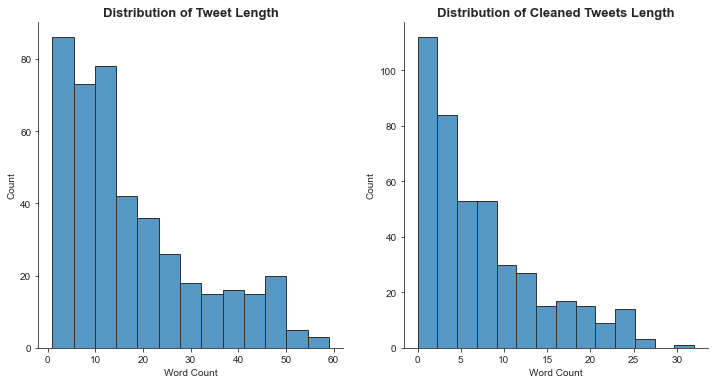

In [129]:
print("There are {} total words and {} unique words in the user's tweets.".format(len(all_words), len(vocab)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

sns.histplot(tweet_length, edgecolor='.2', ax=ax[0])
ax[0].set(xlabel='Word Count')
ax[0].set_title('Distribution of Tweet Length', fontweight='bold', fontsize=13)

sns.histplot(clean_tweet_length, edgecolor='.2', ax=ax[1])
ax[1].set(xlabel='Word Count')
ax[1].set_title('Distribution of Cleaned Tweets Length', fontweight='bold', fontsize=13)

sns.despine()
plt.show()

Looking at the histogram, I will filter the tweets to that containing more than 5 words. I think tweets containing less than that might not be useful.

In [130]:
tweets = tweets[tweets['clean-len'] >= 5]

## Sentiment Analysis

### Vader Sentiment Analysis

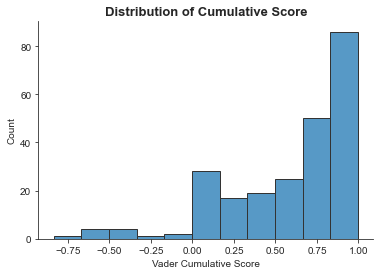

In [131]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
tweets['vader-sentiment'] = tweets['tweet'].apply(lambda x: analyzer.polarity_scores(x))
tweets['vader-pos'] = tweets['vader-sentiment'].apply(lambda x: x['pos'])
tweets['vader-neu'] = tweets['vader-sentiment'].apply(lambda x: x['neu'])
tweets['vader-neg'] = tweets['vader-sentiment'].apply(lambda x: x['neg'])
tweets['vader-compound'] = tweets['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(tweets['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

We only want to recommend gifts based on positive tweets. To obtain extremely positive tweets, I'll filter to tweets that contain a cumulative score greater than 0.3.

In [132]:
tweets_filtered = tweets[tweets['vader-compound'] >= 0.3]
tweets_filtered.shape

(184, 9)

## Each Tweet as Classifier Input

In [133]:
clean_tweets = tweets_filtered['clean-tweets'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)

In [153]:
nb_series = pd.Series(nb_topic_pred).value_counts()
nb_series

Books                  69
Movies                 35
Music                  29
Travel                 12
Alcohol                 7
Self-care               5
Sports                  5
Household               4
Electronics/Gadgets     4
Nature                  4
Coffee                  4
Gamers                  4
Art                     1
Food                    1
dtype: int64

In [156]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Music     63
Movies    21
Nature    19
dtype: int64

### Test by Self-Labelling Tweets

In [137]:
labels = ['Self-care', 'Music', 'Movies', 'Not Useful', 'Not Useful', 'Not Useful', 'Not Useful', 'Not Useful',
         'Not Useful', 'Not Useful', 'Not Useful', 'Movies', 'Movies', 'Not Useful', 'Music', 'Music', 'Not Useful',
         'Music', 'Nature', 'Music', 'Music', 'Movies', 'Movies', 'Movies', 'Sports', 'Music', 'Music', 'Movies',
         'Not Useful', 'Music', 'Travel', 'Not Useful', 'Self-care', 'Not Useful', 'Not Useful', 'Alcohol', 'Movies',
         'Movies', 'Music', 'Music', 'Self-care', 'Books', 'Music', 'Music', 'Music', 'Music', 'Music', 'Not Useful',
         'Travel', 'Music', 'Music', 'Nature', 'Music', 'Music', 'Music', 'Music', 'Music', 'Household', 'Music', 'Music']

key = {v: k for k, v in ref.items()}

test = clean_tweets[:60]
test_df = pd.DataFrame({'clean-tweets': test, 'target': labels})
test_df = test_df[test_df.target != 'Not Useful']
X = test_df['clean-tweets']
y = [key[item] for item in test_df['target']]
X_transformed = tfidf_model.transform(X)

print('Naive Bayes Score: ', nb.score(X_transformed, y))
print('Support Vector Classifier Score: ', ovr_svc.score(X_transformed, y))

Naive Bayes Score:  0.3333333333333333
Support Vector Classifier Score:  0.4444444444444444


## Topic Modelling as Classifier Input

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF

### TF-IDF Vectorizer

In [139]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_transform = tfidf.fit_transform(tweets_filtered['clean-tweets'])
tfidf_feature_names = tfidf.get_feature_names()

### Count Vectorizer

In [140]:
cv = CountVectorizer(stop_words='english')
cv_transform = cv.fit_transform(tweets_filtered['clean-tweets'])
cv_feature_names = cv.get_feature_names()

In [141]:
def display_topics(model, feature_names, no_top_words):
    topic_words = list()
    for topic_idx, topic in enumerate(model.components_):
        topic_words.append((topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])))
    return topic_words

### NMF + TFIDF

In [142]:
no_topics = 3
nmf = NMF(n_components=no_topics, random_state=1, alpha=0.1, init='nndsvd')
nmf_output = nmf.fit_transform(tfidf_transform)
topic_words = display_topics(nmf, tfidf_feature_names, 20)
print(topic_words)

[(0, 'video calm need music premiere new friend tomorrow ask scene midnight delicate tonight song award live eastern est world watch'), (1, 'lover love album new listen song celebration finally make taylorswift available stream playlist shop share preorder favorite excited playlistbyme play'), (2, 'thank make say like want time good feel work awesome taylor thing grin day swift man play nice entire fun')]


### NMF + Count Vectorizer


In [145]:
no_topics = 3
nmf = NMF(n_components=no_topics, random_state=1, alpha=0.1, init='nndsvd')
nmf_output = nmf.fit_transform(cv_transform)
topic_words = display_topics(nmf, cv_feature_names, 20)
print(topic_words)

[(0, 'thank want say feel like make work time entire good man huge awesome year come thing fun happy interview word'), (1, 'lover make album song play love new want way listen shop taylor day festival celebrate available watch like perform excited'), (2, 'video music calm song need new premiere work year scene guy friend amazing midnight man lover live tomorrow ask debut')]


### LDA + TF-IDF

In [117]:
no_topics = 3
lda=LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=0)
lda_output = lda.fit_transform(tfidf_transform)
lda_topic = display_topics(lda, tfidf_feature_names, 20)
print(lda_topic)

[(0, 'make love thank video song lover guy snl new swift taylor grin million tonight album platinum finally rehearsal day santa'), (1, 'scene thank check shop video want performance song vertical album lover available like time favorite congratulation shoot day amazing good'), (2, 'video new premiere play thank wait music live song man like watch yes say calm listen available award taylor work')]


#LDA or HDA

### LDA + Count Vectorizer

In [19]:
no_topics = 3
lda=LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=0)
lda_output = lda.fit_transform(cv_transform)
lda_topic = display_topics(lda, cv_feature_names, 20)
print(lda_topic)

[(0, 'thank love make song video want lover new guy say time day good feel tonight taylor album know music today'), (1, 'night amazing shop lover available like video album scene shoot check taylor bundle cat meet meredith performance set riaas date'), (2, 'like video song play new wait live yes taylor day watch dress music premiere make midnight available team reputation single')]


## Predictions

In [146]:
nb_predictions = list()
svc_predictions = list()
nb_probability = list()
svc_probability = list()

for topic in topic_words:
    nb_topic = ref[nb.predict(tfidf_model.transform([topic[1]]))[0]] 
    nb_predictions.append(nb_topic)
    nb_probability.append(max(nb.predict_proba(tfidf_model.transform([topic[1]]))[0]))
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([topic[1]]))[0]]
    svc_predictions.append(svc_topic)
    svc_probability.append(max(ovr_svc.decision_function(tfidf_model.transform([topic[1]]))[0]))

In [147]:
print('Naive Bayes Prediction: ', nb_predictions)
print('Support Vector Prediction: ', svc_predictions)

Naive Bayes Prediction:  ['Books', 'Music', 'Music']
Support Vector Prediction:  ['Work', 'Music', 'Music']


In [120]:
svc_probability

[1.1414887643031246, 1.1899218659821837, 0.6427445660302893]

In [121]:
nb_probability

[0.5117206400664555, 0.33476584020797434, 0.36537040981555924]